# **Uploading data from kaggle**

In [1]:
pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shorouqhossam","key":"1c5ae42ea7c0811336904dd1706bc201"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/



!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download -c rossmann-store-sales

 72% 5.00M/6.99M [00:00<00:00, 51.7MB/s]
100% 6.99M/6.99M [00:00<00:00, 67.9MB/s]


In [6]:
! unzip rossmann-store-sales.zip

Archive:  rossmann-store-sales.zip
  inflating: sample_submission.csv   
  inflating: store.csv               
  inflating: test.csv                
  inflating: train.csv               


# **Required libraries**

In [7]:
# Install necessary libraries
!pip install pmdarima
!pip install git+https://github.com/statsmodels/statsmodels.git@74836e9cf2198ac7a930146405da7239c0823a9b#egg=statsmodels
!pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.9 MB/s eta 0:00:00
  Cloning https://github.com/statsmodels/statsmodels.git (to revision 74836e9cf2198ac7a930146405da7239c0823a9b) to /tmp/pip-install-_zgyunhb/statsmodels_c07f6c106d5340dab559b4d9c4e61e55
  Running command git clone --filter=blob:none --quiet https://github.com/statsmodels/statsmodels.git /tmp/pip-install-_zgyunhb/statsmodels_c07f6c106d5340dab559b4d9c4e61e55
  Running command git rev-parse -q --verify 'sha^74836e9cf2198ac7a930146405da7239c0823a9b'
  Running command git fetch -q https://github.com/statsmodels/statsmodels.git 74836e9cf2198ac7a930146405da7239c0823a9b
  Running command git checkout -q 74836e9cf2198ac7a930146405da7239c0823a9b
  Resolved https://github.com/statsmodels/statsmodels.git to commit 74836e9cf2198ac7a930146405da7239c0823a9b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for statsmodels: f

In [165]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from lightgbm import LGBMRegressor
from prophet import Prophet
import logging
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from itertools import product
logging.getLogger("cmdstanpy").disabled = True

# **Data reading**

In [44]:
# Reading the dataset
df = pd.read_csv('/content/train.csv')
store = pd.read_csv('/content/store.csv')

# Merge datasets
df = df.merge(store, on='Store', how='left')

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as index
df.set_index('Date', inplace=True)

df.head()


<ipython-input-44-6c2e6a3a069a>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/train.csv')


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2015-07-31,2,5,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2015-07-31,3,5,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2015-07-31,4,5,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
2015-07-31,5,5,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Sales                      1017209 non-null  int64  
 3   Customers                  1017209 non-null  int64  
 4   Open                       1017209 non-null  int64  
 5   Promo                      1017209 non-null  int64  
 6   StateHoliday               1017209 non-null  object 
 7   SchoolHoliday              1017209 non-null  int64  
 8   StoreType                  1017209 non-null  object 
 9   Assortment                 1017209 non-null  object 
 10  CompetitionDistance        1014567 non-null  float64
 11  CompetitionOpenSinceMonth  693861 non-null   float64
 12  CompetitionOpenSinceYear   693861 non-null   float64
 1

# **Data preparation**

- **Choose the specific store**

In [46]:
df = df[df["Store"] == 2]

- **Check for nulls**

In [47]:

df.isnull().sum()

Store                        0
DayOfWeek                    0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

- **Set frequency to daily**

In [48]:
df = df.asfreq('D')
df.isnull().sum()

Store                        0
DayOfWeek                    0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

- **Remove columns not available in production (Customers)**

In [49]:
df.drop(["Customers"], axis=1, inplace=True)

- **Convert categorical columns to numerical**

In [52]:
# Define a dictionary for each categorical column
state_holiday_mapping = {
    "a": 0,
    "b": 1,
    "c": 2,
}
store_type_mapping = {
    "a": 0,
    "b": 1,
    "c": 2,
    "d": 3,
}
assortment_mapping = {
    "a": 0,
    "b": 1,
}
promo_interval_mapping = {
    "Jan,Apr,Jul,Oct": 0,
    "Feb,May,Aug,Nov": 1,
    "Mar,Jun,Sept,Dec": 2,
}

# Apply the mappings to the categorical columns
df["StateHoliday"] = df["StateHoliday"].map(state_holiday_mapping)
df["StoreType"] = df["StoreType"].map(store_type_mapping)
df["Assortment"] = df["Assortment"].map(assortment_mapping)
df["PromoInterval"] = df["PromoInterval"].map(promo_interval_mapping)

# **Splitting to train and test**

In [53]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size].copy()
test_data = df[train_size:].copy()


# **EDA**

- **Plot Sales (Entire Train Data)**

Text(0.5, 1.0, 'Sales over Time (Entire Data)')

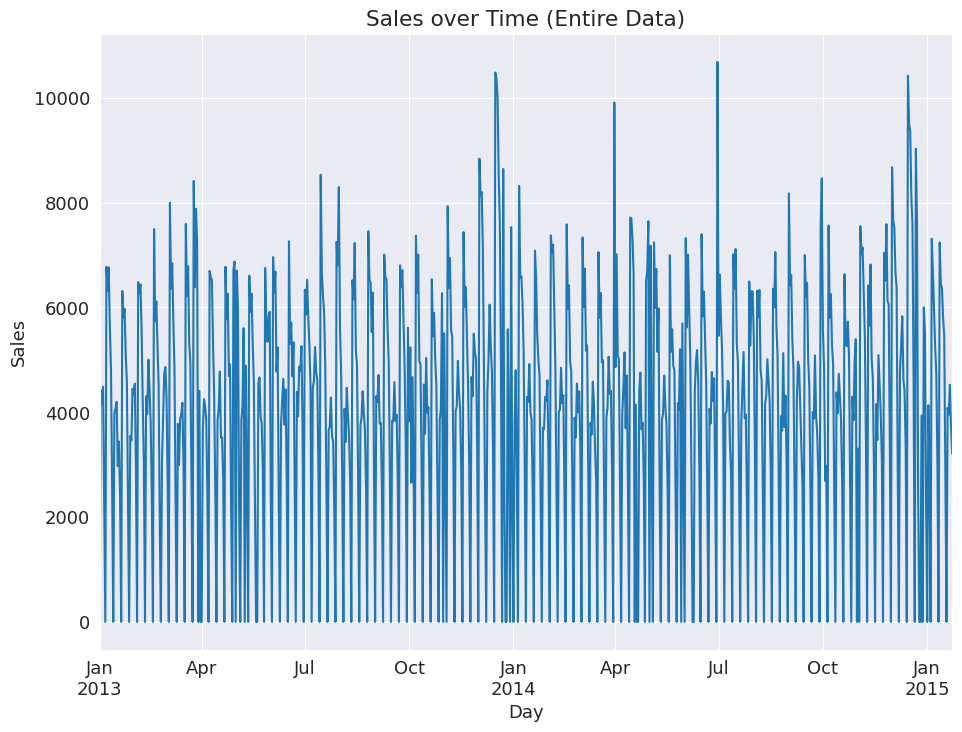

In [54]:
plt.figure(figsize=(11, 8))
train_data['Sales'].plot()
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales over Time (Entire Data)')

- **Plot Sales (One Month)**

Text(0.5, 1.0, 'Sales over Time (One Month)')

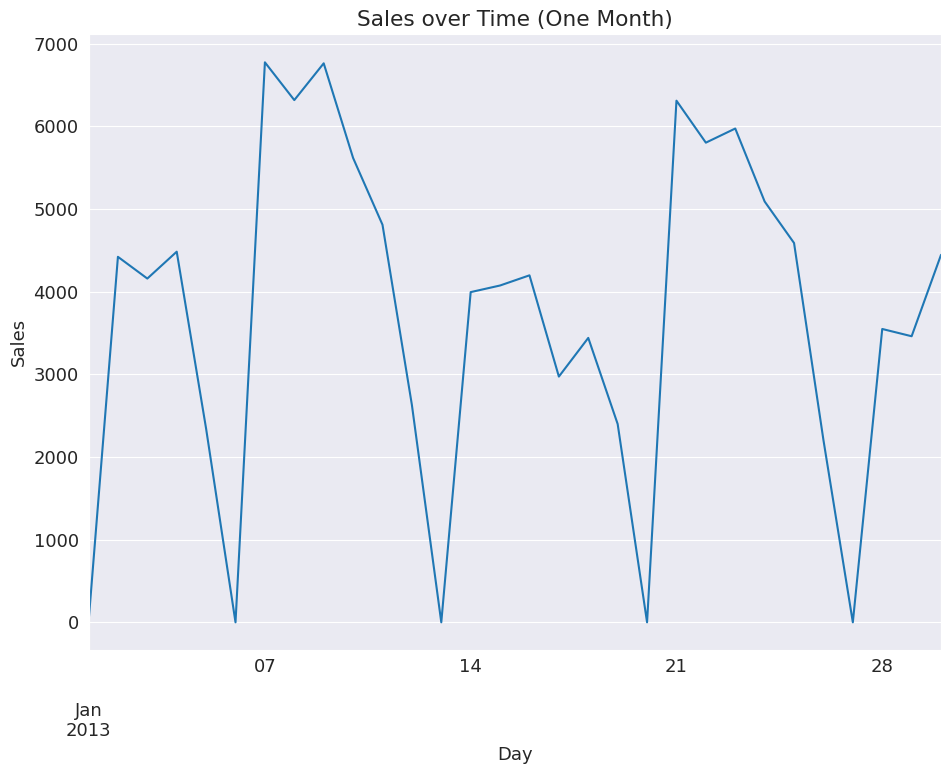

In [55]:

plt.figure(figsize=(11, 8))
train_data['Sales'][:30].plot()
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales over Time (One Month)')

- **Plot Sales (One Year)**

Text(0.5, 1.0, 'Sales over Time (One Year)')

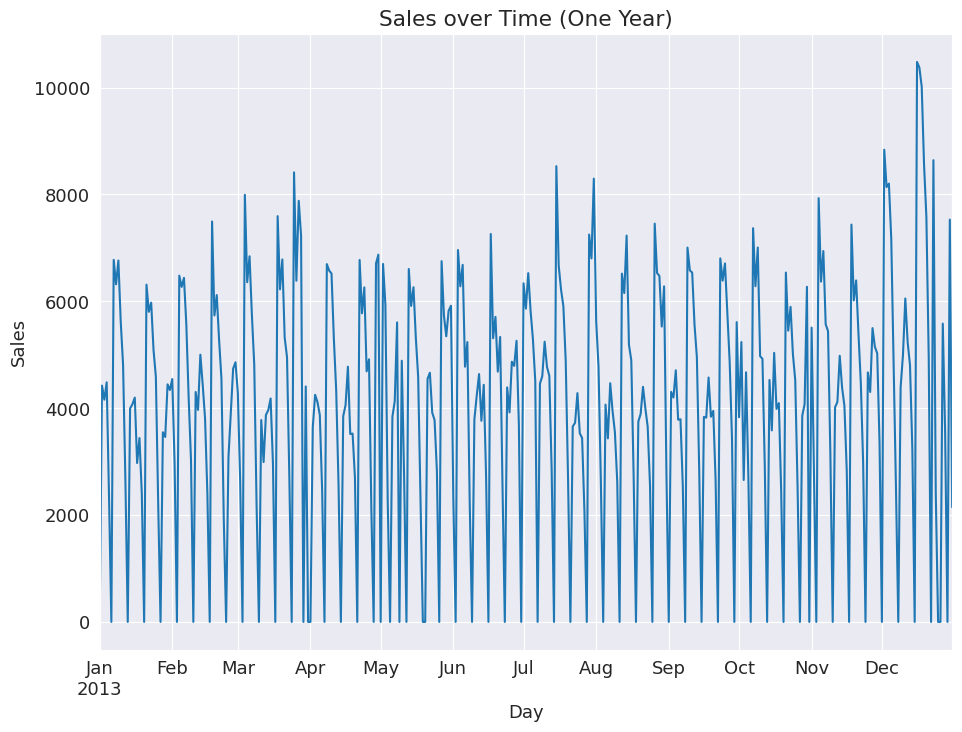

In [56]:
plt.figure(figsize=(11, 8))
train_data['Sales'][:365].plot()
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales over Time (One Year)')

- **Plot Sales in different conditions**

<ipython-input-57-42d4c81f5ce0>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Open', y='Sales', data=train_data, ax=axes[0, 0],palette ="husl")
<ipython-input-57-42d4c81f5ce0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Promo', y='Sales', data=train_data, ax=axes[0, 1],palette ="husl")
<ipython-input-57-42d4c81f5ce0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='StateHoliday', y='Sales', data=train_data, ax=axes[1, 0],palette ="husl")
<ipython-input-57-42d4c81f5ce0>:7: FutureWarning: 

Passing `palette` without assigning 

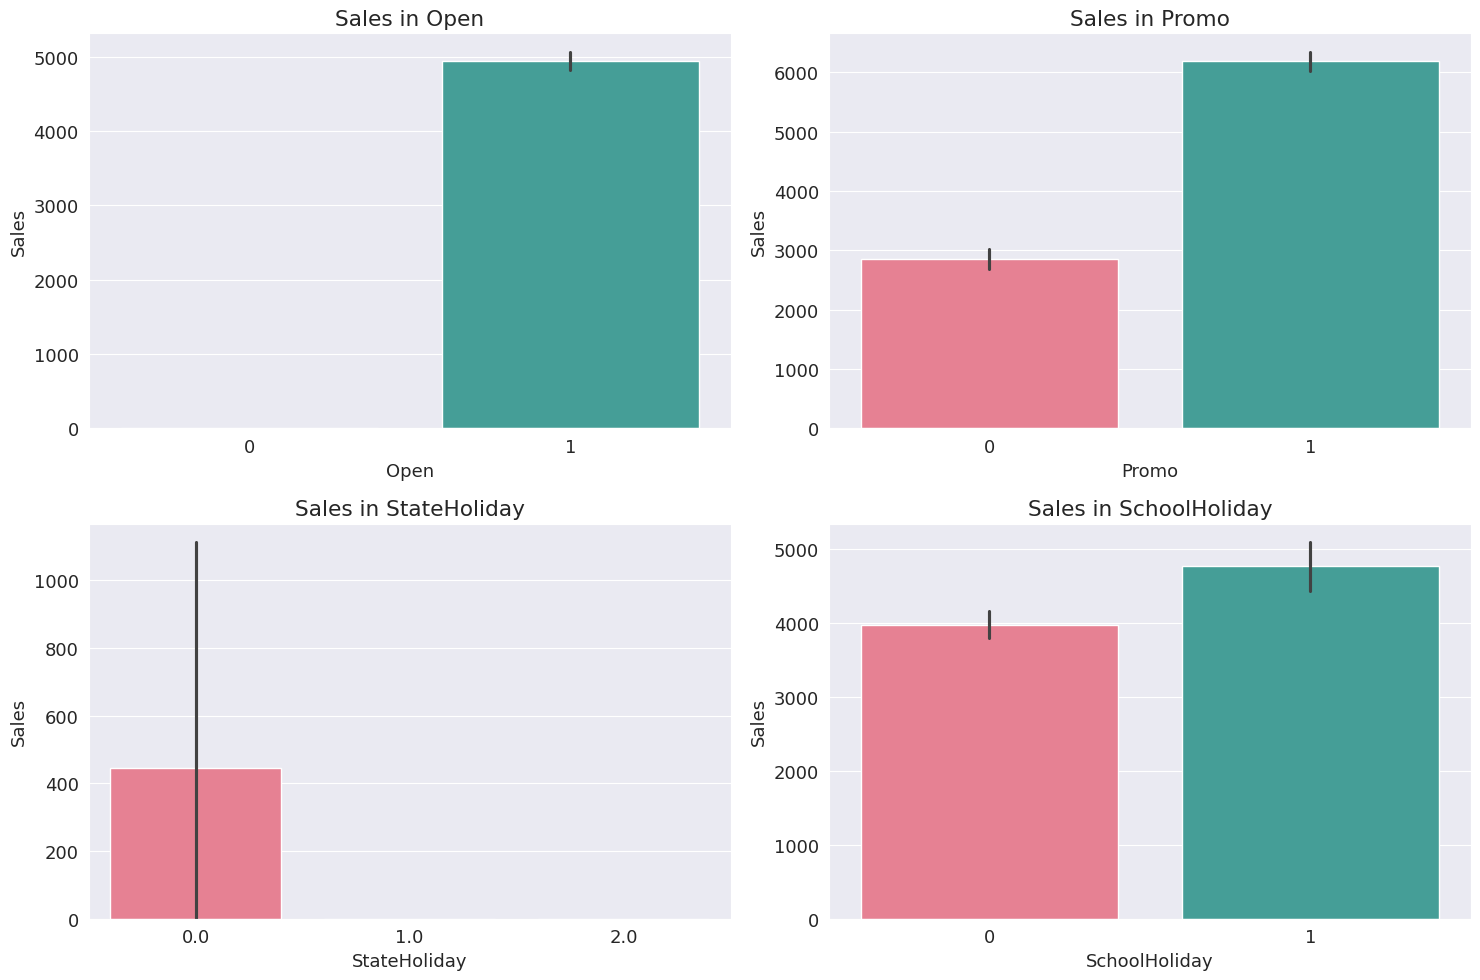

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.set_style("darkgrid")

sns.barplot(x='Open', y='Sales', data=train_data, ax=axes[0, 0],palette ="husl")
sns.barplot(x='Promo', y='Sales', data=train_data, ax=axes[0, 1],palette ="husl")
sns.barplot(x='StateHoliday', y='Sales', data=train_data, ax=axes[1, 0],palette ="husl")
sns.barplot(x='SchoolHoliday', y='Sales', data=train_data, ax=axes[1, 1],palette ="husl")

axes[0, 0].set_title('Sales in Open')
axes[0, 1].set_title('Sales in Promo')
axes[1, 0].set_title('Sales in StateHoliday')
axes[1, 1].set_title('Sales in SchoolHoliday')


plt.tight_layout()
plt.show()

- **`Store Being Open:`** The store needs to be open to generate sales. Closed days result in negligible sales.
-**`Promotions:`** Promotional activities significantly boost sales, nearly doubling the average sales compared to non-promotional periods.
- **`State Holidays:`** Sales are very low on state holidays `a`, but there are no sales recorded for other types of state holidays (`b` and `c`).
- **`School Holiday`**: Sales are higher during school holidays, indicating that these periods might be good times for promotional activities.

# **Apply Simple Forecasting Models**

- **Naive Forecast**

In [58]:
naive_forcast = [train_data["Sales"].iloc[-1]]*len(test_data["Sales"])
naive_prediction = pd.DataFrame(naive_forcast)
naive_prediction.index = test_data.index
naive_prediction.squeeze()

Date
2015-01-24    3206
2015-01-25    3206
2015-01-26    3206
2015-01-27    3206
2015-01-28    3206
              ... 
2015-07-27    3206
2015-07-28    3206
2015-07-29    3206
2015-07-30    3206
2015-07-31    3206
Freq: D, Name: 0, Length: 189, dtype: int64

- **Simple Moving Average**

In [59]:

average_prediction = [train_data['Sales'].mean()]*len(test_data["Sales"])
average_pred = pd.DataFrame(moving_average_prediction)
average_pred.index = test_data.index
average_pred.squeeze()

Date
2015-01-24    4114.922975
2015-01-25    4114.922975
2015-01-26    4114.922975
2015-01-27    4114.922975
2015-01-28    4114.922975
                 ...     
2015-07-27    4114.922975
2015-07-28    4114.922975
2015-07-29    4114.922975
2015-07-30    4114.922975
2015-07-31    4114.922975
Freq: D, Name: 0, Length: 189, dtype: float64

# **Evaluation**

In [60]:
# Evaluation function
def evaluate_forecast(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)

In [61]:
print(f"RMSPE for Average method:{evaluate_forecast(average_pred, test_data[['Sales']])}")
print(f"RMSE for Naive Forecast:{evaluate_forecast(naive_prediction, test_data[['Sales']])}")

RMSPE for Average method:0.5707736265683365
RMSE for Naive Forecast:0.7900502085911463


+ naive method is better than the average method

- **Make the prediction value = 0 when store is not opened**

In [62]:
for pred in [average_pred,naive_prediction]:
    pred[test_data["Open"] == 0] = 0

- **Plotting predictions**

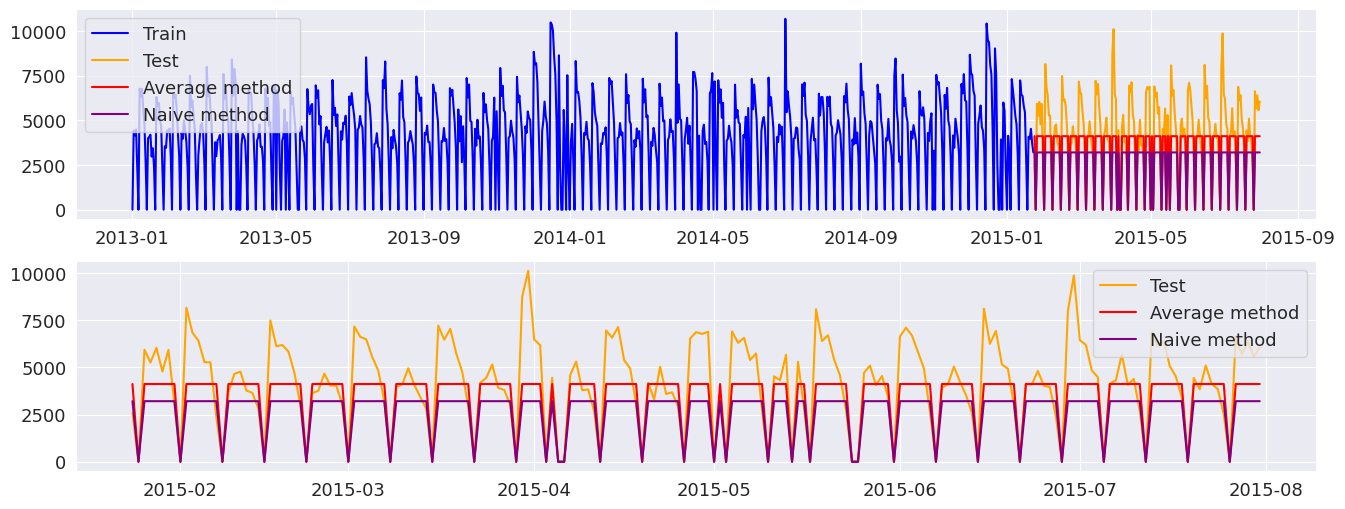

In [63]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(average_pred,label="Average method",color='red')
axes[0].plot(naive_prediction,label="Naive method",color='purple')

axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(average_pred,label="Average method",color='red')
axes[1].plot(naive_prediction,label="Naive method",color='purple')

axes[1].legend(loc='best')
plt.show()



# **MSTL Model**

In [64]:
# seasonal period: weekly, monthly, and annually
mstl = MSTL(train_data["Sales"], periods=(7, 30, 365), stl_kwargs={"seasonal_deg": 0})
result = mstl.fit()

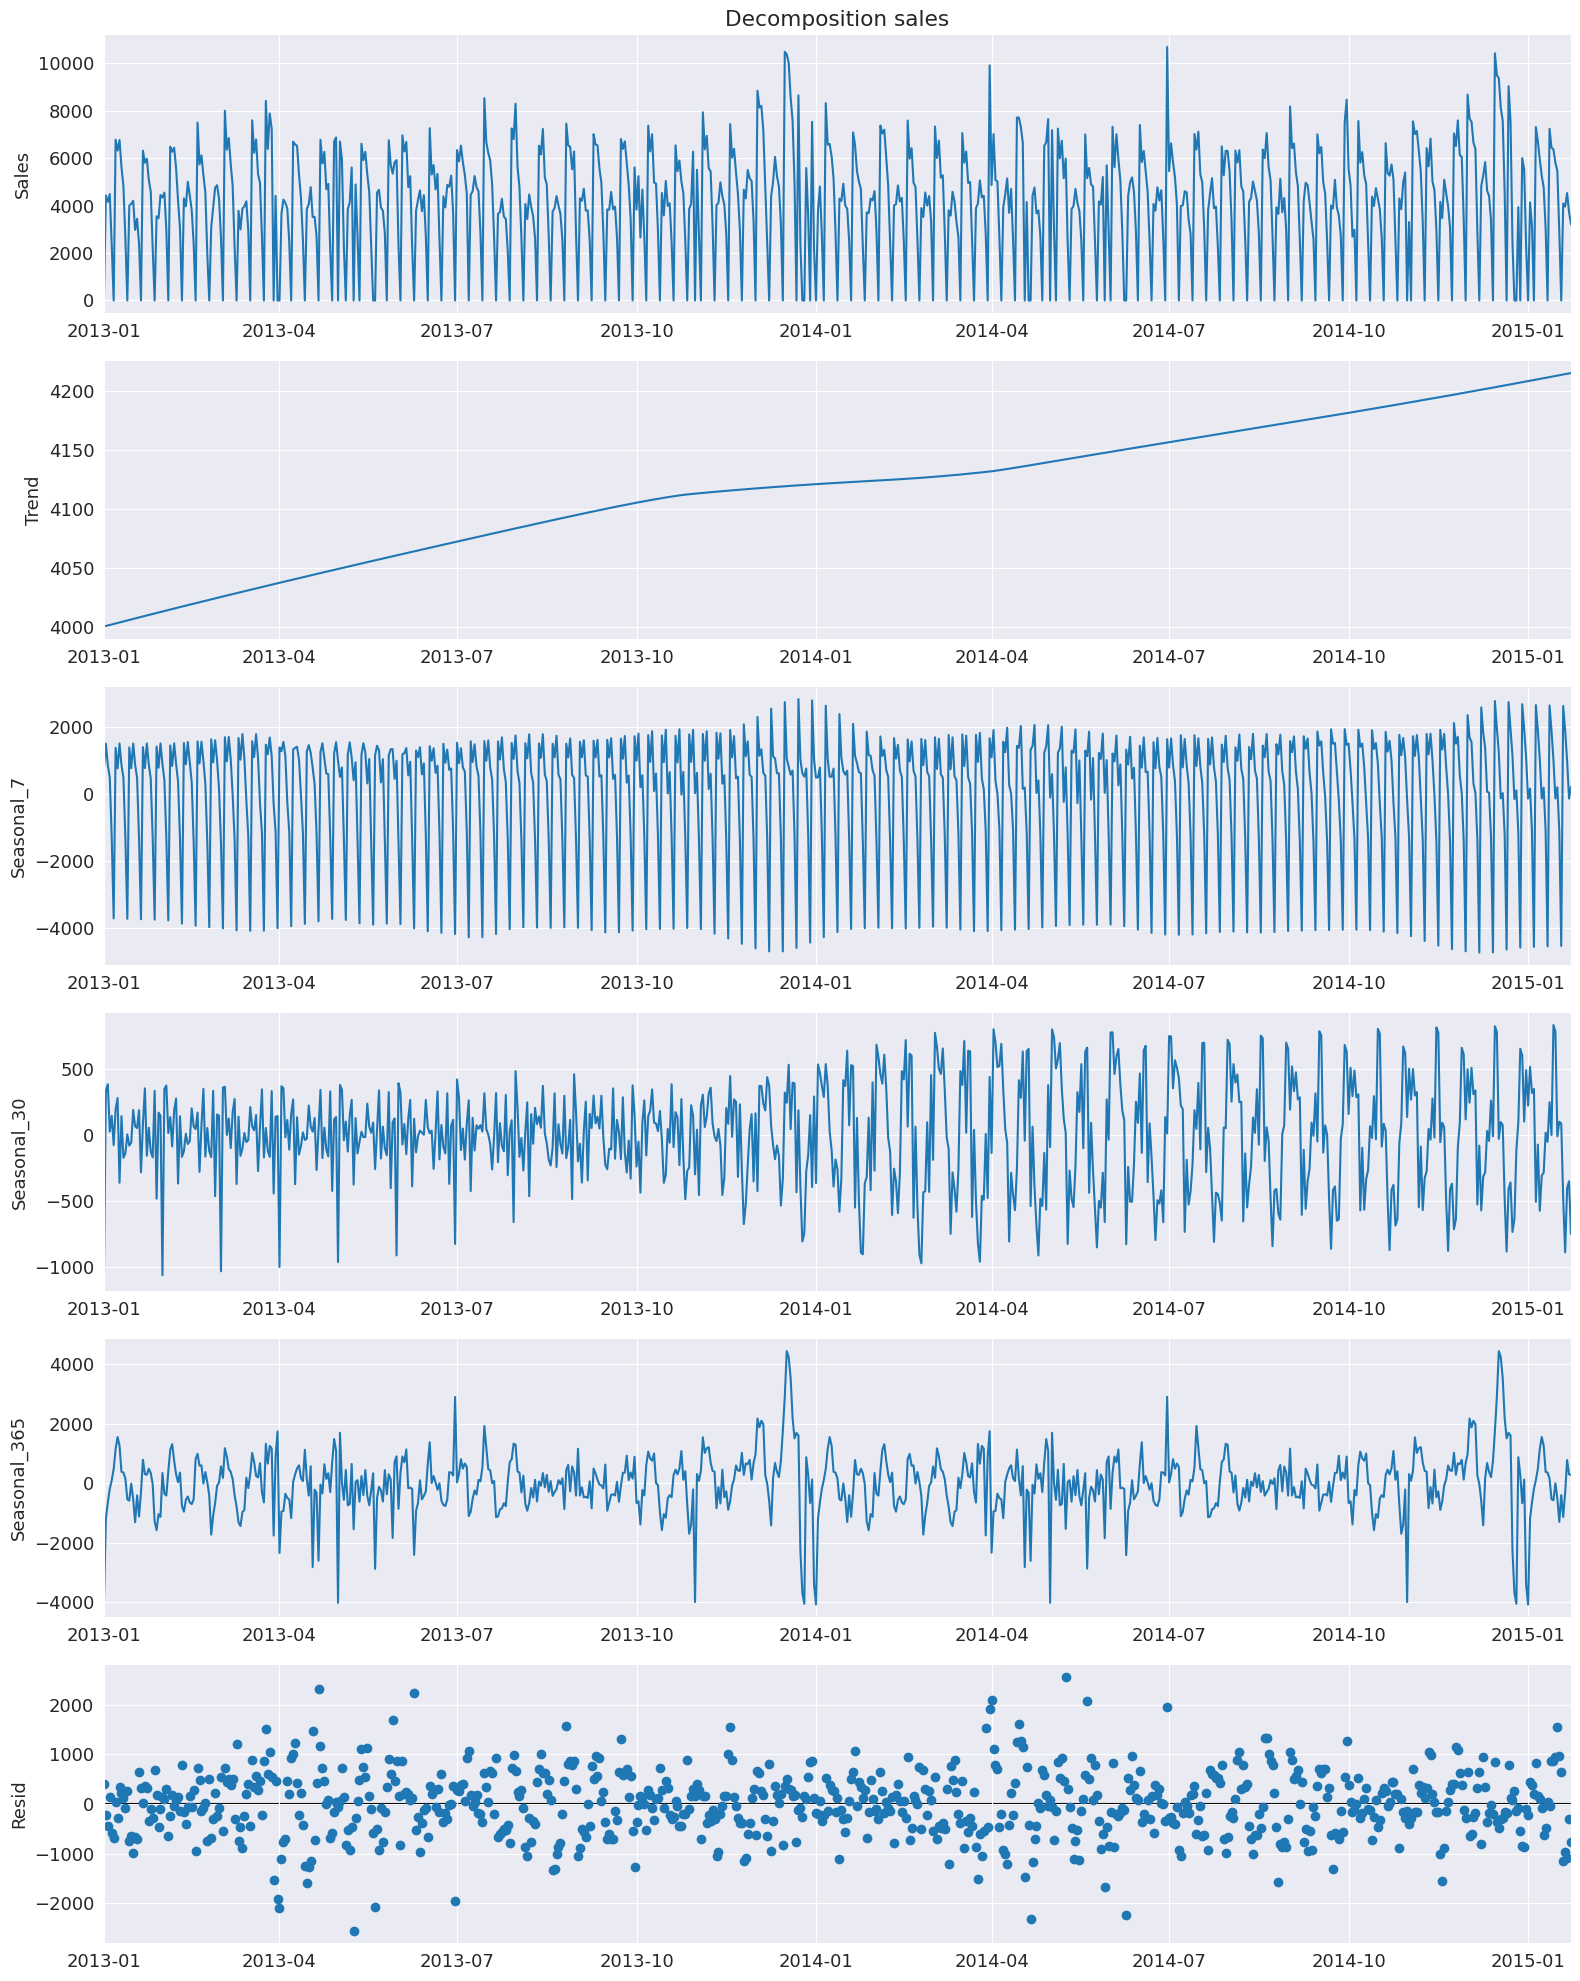

In [65]:
# Start with the plot from the results object `result`
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = result.plot()

# Make plot pretty
axs = fig.get_axes()

axs[0].set_ylabel("Sales")
axs[0].set_title("Decomposition sales")

plt.tight_layout()

# **Arima model**

- **Define kpss_test function**

In [69]:
def kpss_test(data,threshold=0.05,regression="c"):
    result = kpss(data,regression="c")
    #print(result)
    # Print test results
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Lags Used:', result[2])
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t{}: {}'.format(key, value))
    if result[1]<=threshold:
        print("The data is not stationary")
    else:
        print("The data is stationary")

- **Define adf_test function**

In [70]:
def adf_test(data,threshold=0.05):
    # Perform ADF test
    result = adfuller(data,autolag="AIC")

    # Print test results
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

    if result[1] <= threshold:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

- **Define autocorrelatin_graphs function**

In [71]:
def autocorrelatin_graphs(value,n_lags,title_text):
    fig, axes = plt.subplots(3,1,dpi=80)
    fig.set_figheight(12)
    fig.set_figwidth(16)
    value_plot = axes[0].plot(value)
    plt.title(f'{title_text}')
    acf_plot = plot_acf(value, lags=n_lags, title=f'Autocorrelation in {title_text}',ax=axes[1])
    plt.xlabel('Lags')
    pacf_plot = plot_pacf(value, lags=n_lags, title=f'Partial Autocorrelation in {title_text}',ax=axes[2])
    plt.xlabel('Lags')
    plt.tight_layout()
    plt.show()

- **Plot Rolling mean and STD**

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

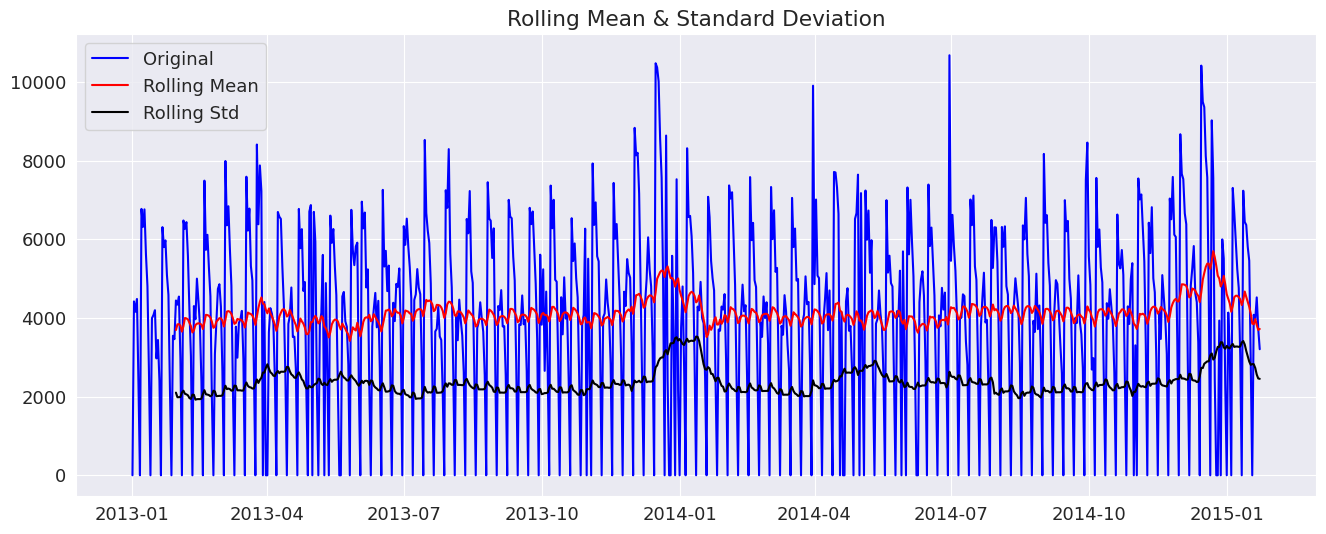

In [75]:
fig ,axes =plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(16)

#Determing rolling statistics
rolmean = train_data[["Sales"]].rolling( window=30).mean()
rolstd = train_data[["Sales"]].rolling(window=30).std()

#Plot rolling statistics:
orig = axes.plot(train_data[["Sales"]], color='blue',label='Original')
mean = axes.plot(rolmean, color='red', label='Rolling Mean')
std = axes.plot(rolstd, color='black', label = 'Rolling Std')
axes.legend(loc='best')
axes.set_title('Rolling Mean & Standard Deviation')

- **Check stationarity**

In [76]:
adf_test(train_data[["Sales"]])

ADF Statistic: -5.298780227104839
p-value: 5.50759945072425e-06
Critical Values:
	1%: -3.439314999916068
	5%: -2.8654965012008677
	10%: -2.5688768817372867
Conclusion:====>
Reject the null hypothesis
Data is stationary


In [77]:
kpss_test(train_data[["Sales"]])

KPSS Statistic: 0.3461420742155137
p-value: 0.1
Lags Used: 41
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
The data is stationary


<ipython-input-69-e92108a7be58>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(data,regression="c")


**In the first look, data seems to be stationary. Despite that, the tests :one confirm that the data is stationary. and the other is not**

- **Autocorrelatin Graphs**

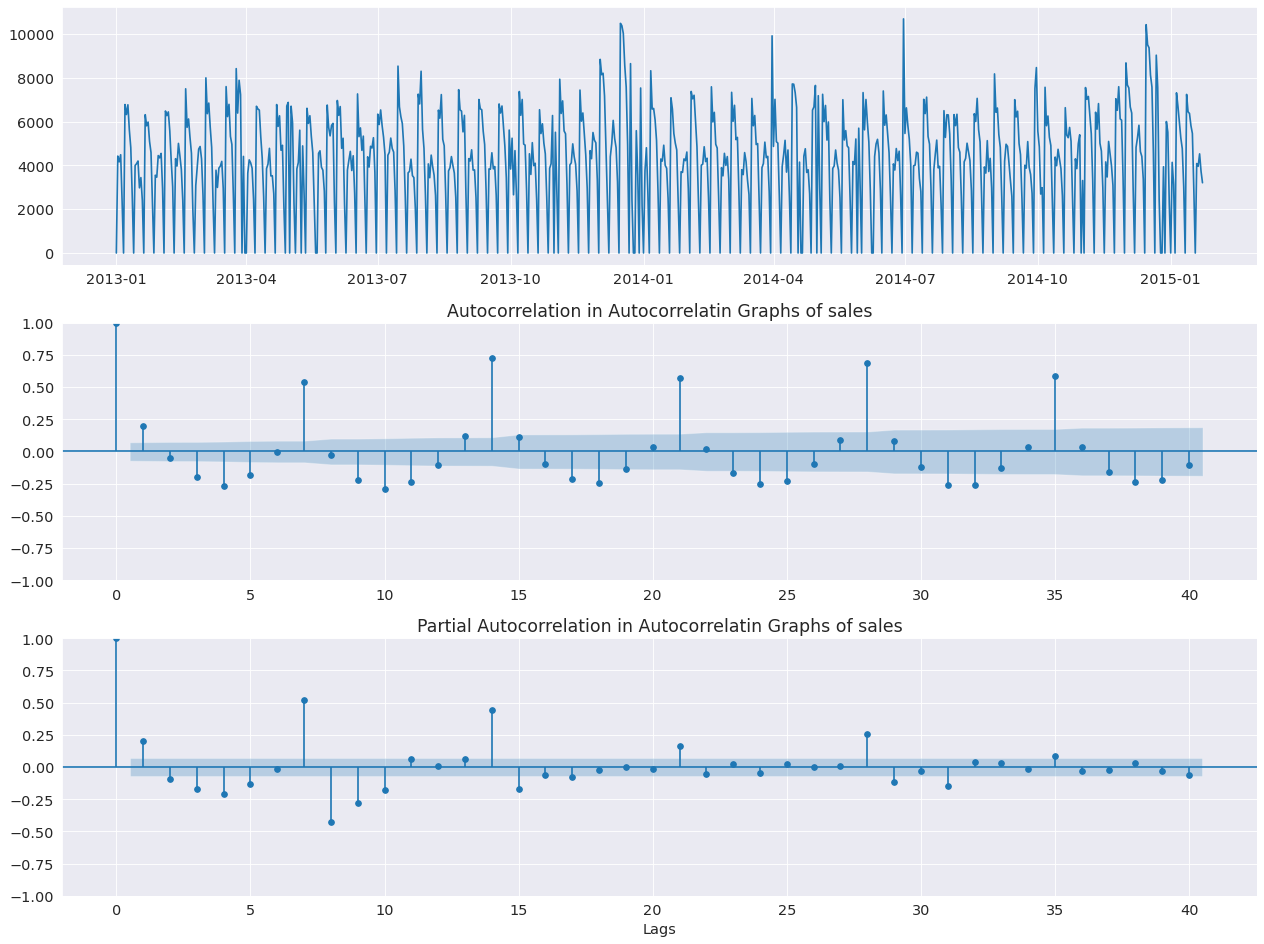

In [79]:
autocorrelatin_graphs(train_data[["Sales"]], n_lags=40, title_text="Autocorrelatin Graphs of sales")

**The autocorrelation and partial autocorrelation plots indicate significant periodic patterns in the sales data, with notable spikes around lag 7 and lag 14, suggesting weekly and bi-weekly cycles in sales.**

- **Arima**

In [80]:
# fit model
ARIMA_model = ARIMA(train_data[["Sales"]], order=(1, 1, 1))
ARIMA_model_fit = ARIMA_model.fit()

In [81]:
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  753
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6897.766
Date:                Fri, 07 Jun 2024   AIC                          13801.531
Time:                        18:41:49   BIC                          13815.399
Sample:                    01-01-2013   HQIC                         13806.874
                         - 01-23-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2062      0.031      6.571      0.000       0.145       0.268
ma.L1         -0.9998      0.076    -13.223      0.000      -1.148      -0.852
sigma2      5.387e+06   5.11e+05     10.533      0.000    4.38e+06    6.39e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 1.51
Prob(Q):                              0.63   Prob(JB):                         0.47
Heteroskedasticity (H):               1.14   Skew:                            -0.08
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
start_index = test_data.index.min()
end_index = test_data.index.max()

#Predictions
arima_preds = ARIMA_model_fit.predict(start=start_index, end=end_index)

- **Make the value of prediction = 0 , when store is not opened**

In [83]:
arima_preds[test_data["Open"] == 0] = 0

- **Evaluation**

In [85]:
print(f'RMSPE for Arima on test:{evaluate_forecast(arima_preds,test_data[["Sales"]])}')

RMSPE for Arima on test:0.477577059649584


- **Plotting**

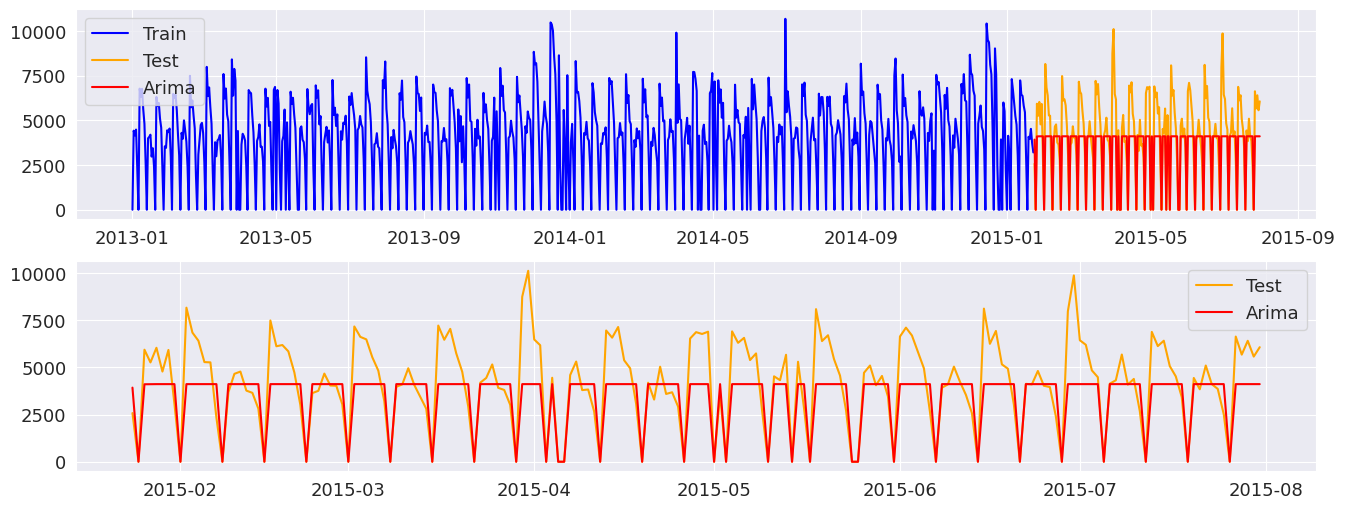

In [86]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(arima_preds,label="Arima",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(arima_preds,label="Arima",color='red')
axes[1].legend(loc='best')
plt.show()

# **Prophet**

- **preparing data function**

In [109]:
def prepare_df_prophet(df, Type="train"):
    new_df = df.copy(deep=True)
    new_df.drop(["Store","StateHoliday"], inplace=True, axis=1)
    new_df['Day'] = new_df.index.day.astype(int)
    new_df['Month'] = new_df.index.month.astype(int)
    new_df['Year'] = new_df.index.year.astype(int)
    new_df['DayOfYear'] = new_df.index.dayofyear.astype(int)
    new_df['WeekOfYear'] = new_df.index.isocalendar().week.astype(int)
    new_df = new_df.reset_index()
    new_df.rename({"Sales": "y", "Date" : "ds"},axis=1, inplace = True)
    if Type == "test":
        new_df.drop("y", axis=1, inplace=True)
    return new_df

In [110]:
train_prophet = prepare_df_prophet(train_data)

In [111]:
Prophet_model = Prophet()

#adding all features as regressors
regressors = ['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Day',
              'Month', 'Year', 'DayOfYear', 'WeekOfYear']

for regressor in regressors:
    Prophet_model.add_regressor(regressor)

- **Fitting**

In [112]:
Prophet_model.fit(train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


- **Preparing the tset data and predicting**

In [113]:
test_prophet = prepare_df_prophet(test_data, Type="test")
forecast = Prophet_model.predict(test_prophet)

In [119]:
prophet_predictions = forecast.copy(deep=True)
prophet_predictions = prophet_predictions.set_index("ds")["yhat"].clip(lower=0)

- **Make the value of prediction = 0 , when store is not opened**

In [120]:
prophet_predictions[test_data["Open"] == 0] = 0

- **Evaluation**

In [139]:
print(f'RMSPE for prophet on test:{evaluate_forecast(prophet_predictions,test_data[["Sales"]])}')

RMSPE for prophet on test:0.1561328960273021


- **Plotting**

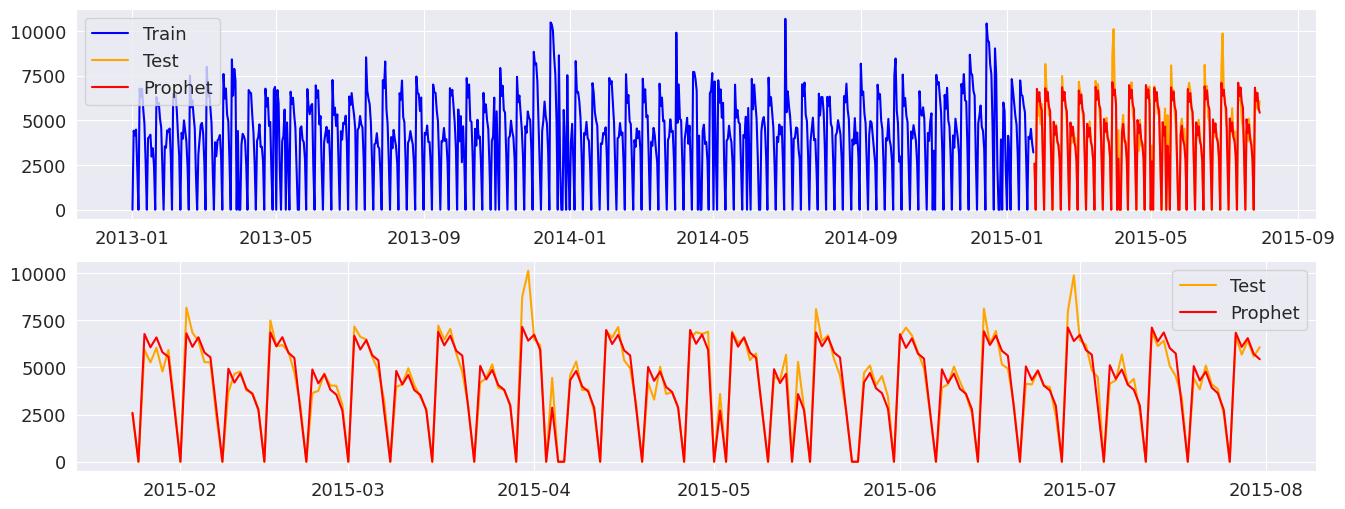

In [124]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(prophet_predictions,label="Prophet",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(prophet_predictions,label="Prophet",color='red')
axes[1].legend(loc='best')
plt.show()

# Machine Learning model

- **Data preparing**

In [126]:
def prepare_df_ml(df):
    new_df = df.copy(deep=True)
    new_df.drop(["Store","StateHoliday"], inplace=True, axis=1)
    new_df['Day'] = new_df.index.day.astype(int)
    new_df['Month'] = new_df.index.month.astype(int)
    new_df['Year'] = new_df.index.year.astype(int)
    new_df['DayOfYear'] = new_df.index.dayofyear.astype(int)
    new_df['WeekOfYear'] = new_df.index.isocalendar().week.astype(int)
    df_prep_X = new_df.drop("Sales", axis=1)
    df_prep_Y = new_df["Sales"]
    return df_prep_X, df_prep_Y

In [127]:
train_prep_X, train_prep_Y = prepare_df_ml(train_data)

In [128]:
train_prep_Y

Date
2013-01-01       0
2013-01-02    4422
2013-01-03    4159
2013-01-04    4484
2013-01-05    2342
              ... 
2015-01-19    4082
2015-01-20    3955
2015-01-21    4524
2015-01-22    3728
2015-01-23    3206
Freq: D, Name: Sales, Length: 753, dtype: int64

- **Random Forest**

In [129]:
# Fit the model
rf_model = RandomForestRegressor(n_estimators=80)
rf_model.fit(train_prep_X, train_prep_Y)

RandomForestRegressor(n_estimators=80)

- **Prepare the test data**

In [143]:
test_prep_X, test_prep_Y = prepare_df_ml(test_data)

- **Predicting and evaluating**

In [144]:
rf_model_predictions = rf_model.predict(test_prep_X)
rf_model_predictions = rf_model_predictions.clip(min=0)
rf_model_predictions[test_prep_X["Open"] == 0] = 0

In [145]:
print(f'RMSPE for Random forest on Test:{evaluate_forecast(rf_model_predictions,test_prep_Y)}')

RMSPE for Random forest on Test:0.1325648618341098


- **Plotting**

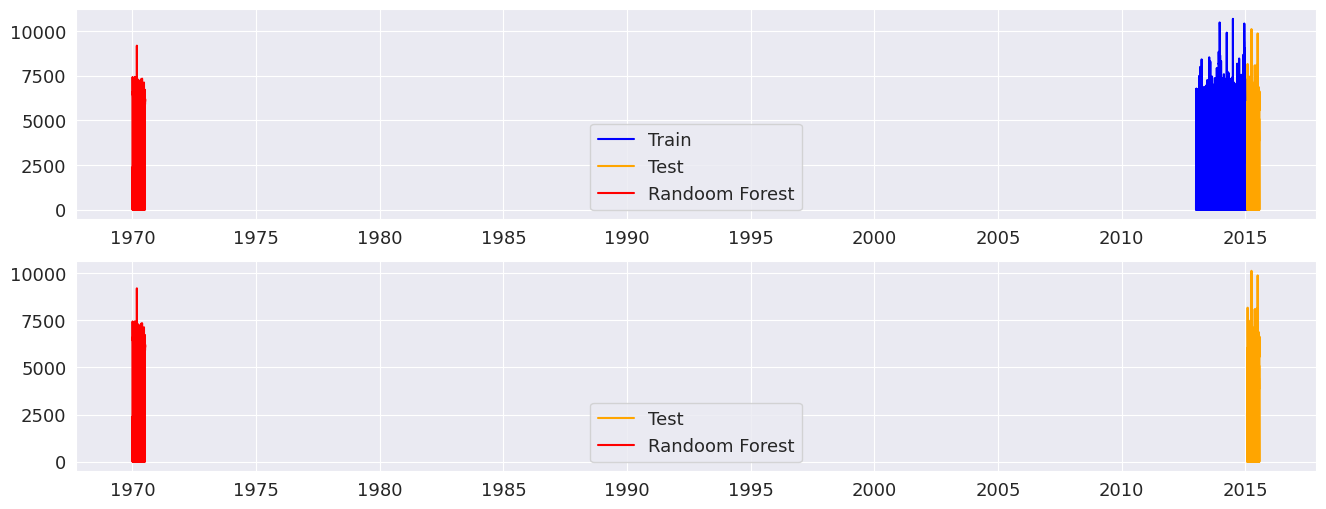

In [146]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(rf_model_predictions,label="Randoom Forest",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(rf_model_predictions,label="Randoom Forest",color='red')
axes[1].legend(loc='best')
plt.show()

### Model Performance Results

| Model                   | RMSPE   |   
|-------------------------|---------|
| Average Method          | 0.5708  |
| Naive Forecast          | 0.7901  |
| ARIMA                   | 0.4776  |
| Prophet                 | 0.1561  |
| Random Forest           | 0.1326  |


## **Best Model:** Random Forest
## **Summary:**
The Random Forest model has the lowest RMSPE (0.1326) among all the models evaluated, indicating that it provides the most accurate forecasts relative to the actual sales values. This model is likely capturing the complexities and patterns in the sales data more effectively than the other models. Given its superior performance, the Random Forest model is the best choice for forecasting sales in this scenario.